In [190]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import time

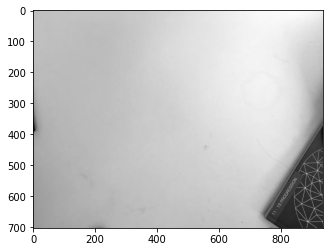

In [191]:
img1 = imread('image1')
if img1.ndim == 3:
    img1 = img1.mean(axis=2)

img2 = imread('image2')
if img2.ndim == 3:
    img2 = img2.mean(axis=2)
    
plt.imshow(img2, cmap='gray')

In [192]:
def median_filter(input_image, s):
    new_image = np.zeros((input_image.shape[0], input_image.shape[1]))
    for r in range(0, input_image.shape[1]):
        for c in range(0, input_image.shape[0]):
            values = []
            for ri in range(max(0, r - s), min(input_image.shape[1], r + s)):
                for ci in range(max(0, c - s), min(input_image.shape[0], c + s)):
                    values.append(input_image[ci, ri])
            values = sorted(values)
            new_image[c, r] = values[int(len(values) / 2)]

    return new_image

In [193]:
threshold_function = lambda image, threshold : np.asarray([[pixel>=threshold for pixel in row] for row in image])

In [194]:
downsize = lambda img, sf : np.array([[img[j, i] for i in range(0, len(img[0]), sf)] for j in range(0, len(img), sf)])

In [195]:
def DBSCAN(image, radius, core_threshold):

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append([(y,x), 0])

  groups = [0]  # group 0 -> noise (default)

  for point in points:

    surrounding_points = []
    for other_point in points:
      if ((point[0][0] - other_point[0][0])**2 + (point[0][1] - other_point[0][1])**2)**0.5 <= radius and point != other_point:
        surrounding_points.append(other_point)
    
    if len(surrounding_points) >= core_threshold:

      if sum([p[1] for p in surrounding_points]) == 0:  # no groups
        new_group = groups[-1] + 1
        groups.append(new_group)

        for p in surrounding_points:
          p[1] = new_group  # changes main points list as list is reference

      elif sum([p[1]>0 for p in surrounding_points]) == 1:  # one group
        
        group = -1  # group should never stay -1
        for p in surrounding_points:
            group = p[1] if p[1] > 0 else group

        for p in surrounding_points:
          p[1] = group

      else:  # >1 group

        surrounding_groups = []
        for p in surrounding_points:
            if p[1] not in surrounding_groups and p[1] != 0:
              surrounding_groups.append(p[1])

        for p in surrounding_points:
          p[1] = surrounding_groups[0]

        for p in points:
          if p[1] in surrounding_groups:
            p[1] = surrounding_groups[0]

  del groups[0]  # noise group
  centres = [[0, 0] for i in groups]
  totals = [0 for i in groups]

  for point in points:
    if point[1] != 0:
      centres[groups.index(point[1])][0] += point[0][0]
      centres[groups.index(point[1])][1] += point[0][1]
      totals[groups.index(point[1])] += 1

  for i in range(len(groups)):
    if totals[i] > 0:
      centres[i][0] /= totals[i]
      centres[i][1] /= totals[i]

  loss = 0
  for point in points:
    distances = np.array([((point[0][0] - centre[0])**2 + (point[0][1] - centre[1])**2)**0.5 for centre in centres])
    loss += min(distances)

  del_list = []
  for i in range(len(centres)):
    if centres[i] == [0, 0]:
      del_list.append(i)
  for i in sorted(del_list)[::-1]: del centres[i]

  return points, centres, loss

In [201]:
scaling = 8
filter_radius = 2
threshold = 60
dbscan_radius = 5
dbscan_core_threshold = 5

In [202]:
start_time = time.clock()
img = np.absolute(img1 - img2)
img = downsize(img, scaling)
img = median_filter(img, filter_radius)
img = threshold_function(img, threshold)
centres = DBSCAN(img, dbscan_radius, dbscan_core_threshold)[1]
print(centres)
print(f"Time elapsed: {round(time.clock() - start_time, 2)}s")

[[12.252252252252251, 77.74774774774775], [31.079470198675498, 38.22516556291391], [39.93409090909091, 21.845454545454544], [33.0, 75.42857142857143], [38.0, 0.0], [60.93827160493827, 108.77777777777777], [65.64978902953587, 81.0464135021097], [67.86792452830188, 37.79245283018868], [77.0, 111.5], [86.2, 50.5], [86.46153846153847, 93.92307692307692]]
Time elapsed: 1.25s


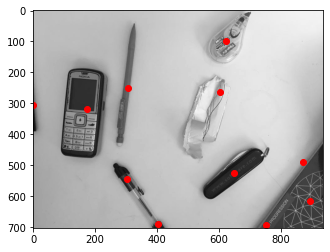

In [203]:
plt.imshow(img1, cmap="gray")
plt.scatter([centre[1]*scaling for centre in centres], [centre[0]*scaling for centre in centres], c="r")
plt.show()

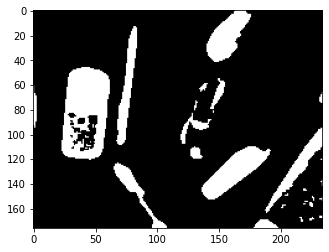

In [204]:
start_time = time.clock()
img = np.absolute(img1 - img2)
img = downsize(img, 4)
img = median_filter(img, 2)
img = threshold_function(img, 40)
plt.imshow(img, cmap="gray")
plt.show()

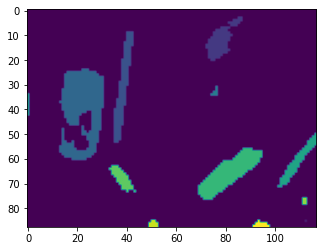

In [205]:
start_time = time.clock()
img = np.absolute(img1 - img2)
img = downsize(img, scaling)
img = median_filter(img, filter_radius)
img = threshold_function(img, threshold)
points = DBSCAN(img, dbscan_radius, dbscan_core_threshold)[0]

temp_image = np.zeros((img.shape[0], img.shape[1]))
for point in points:
  temp_image[point[0][0], point[0][1]] = point[1] + 1
imgplot = plt.imshow(temp_image)